# Sea ice timeseries for ACCESS-OM2_01
TODO: compare thickness with cryosat data


In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import os,sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import netCDF4 as nc
from tqdm import tqdm_notebook
from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
import cmocean as cm
import pandas as pd
import calendar
from datetime import timedelta
from datetime import datetime
import copy

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# set up time units and offset to suit CICE 
# see https://github.com/OceansAus/ACCESS-OM2-1-025-010deg-report/commit/ce3b6331bc4f304d2c5f957ccd2a0ae9ca5d6970#commitcomment-31646163
# for e in exptdata.exptdict.keys():
#     exptdata.exptdict[e]['time_units'] = None

# Set up time_units to suit CICE 
# Only retain netcdf time_units for 0.1 deg.
# We need to change time_units of 1deg and 0.25 deg 
# to shift the time so the last cycle starts in 1958.
# But we don't need offset because CICE time starts at beginning of run, 
# unlike MOM which starts in year 0001.
exptdata.exptdict['01deg']['time_units'] = "days since 1985-01-01"  # don't use None - it leaves the time as cftime

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
initial_transient = True  # whether to just show initial transient

## To deal with memory issues (if needed):
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.11:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.0.64.11:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/aek156`
* Then, make sure the following cell matches the scheduler address.

In [3]:
# cc.start_cluster()  # use Client instead?

In [4]:
exptdata.exptdict

OrderedDict([('1deg',
              {'model': 'access-om2',
               'expt': '1deg_jra55v13_iaf_spinup1_B1',
               'desc': 'ACCESS-OM2',
               'n_files': -12,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1'}),
             ('025deg',
              {'model': 'access-om2-025',
               'expt': '025deg_jra55v13_iaf_gmredi6',
               'desc': 'ACCESS-OM2-025',
               'n_files': -34,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6'}),
             ('01deg',
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_iaf',
               'desc': 'ACCESS-OM2-01',
               'n_files': None,
               'time_units': 'days since 1985-01-01',
               'offset'

In [5]:
# cc.build_index()

In [21]:
figdir = ''
# NOSYNC = '/g/data/v45/aek156/figures/ACCESS-OM2-1-025-010deg-report/figures/ice_validation/NOSYNC/' # where to save figs we don't want to sync
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync

if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)

def savefigure(fname):
    if initial_transient:
        tag = '_initial_transient'
    else:
        tag = ''
    plt.savefig(os.path.join(figdir, fname+tag+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+tag+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [22]:
def fixcicetime(da):
    '''
    Correct the time coordinate in DataArray from CICE netcdf file.
    
    CICE netcdf files unhelpfully have a time coordinate which is just after the end of the averaging period, 
    e.g. the time stamp for a January average is 1 February, which messes up groupby month etc.
    
    This function just subtracts 12 hours to put it in the correct month (and day, for daily means).
    
    PR 109 gives an option to fix this:
    https://github.com/OceansAus/cosima-cookbook/pull/109
    
    '''
    try:
        da['time'] = da.time - np.timedelta64(12, 'h')
    except:
        da['time'] = da.time - timedelta(hours=12)  # for 01deg which for some reason uses cftime
    return da

# use this for DataSet: replaces the bad time dimension with the average of time_bounds.
#     The time type is also changed to datetime64[ns]
#     ds['time'] = ds.time_bounds.astype('int64').mean(axis=1).astype('datetime64[ns]')
    

In [23]:
font = {'size':13}
tick_font=12

In [24]:
# cc.build_index(careful=True)
# cc.build_index()

In [25]:
use_cache = True

In [47]:
if initial_transient:
    # change exptdict to just show the very beginning of the 1 and 0.25 deg runs
    exptdata.exptdict['1deg']['n_files'] = 20*12 # was 4
    exptdata.exptdict['025deg']['n_files'] = 20*12 # was 10
    del exptdata.exptdict['01deg']
    tstart = None
    tend = None
    firstyear = ''
    lastyear = ''
    yearrange = ''
else:
    # use common start and end dates for all runs
    tstart = exptdata.clim_tstart
    tend = exptdata.clim_tend
    firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
    lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
    yearrange = str(firstyear)+'-'+str(lastyear)

print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

KeyError: '01deg'

In [27]:
# Specify paths to observational data

ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsExtNHFileList.sort()
obsExtSHFileList.sort()

In [49]:
del ice_data

NameError: name 'ice_data' is not defined

In [48]:
def loaddata(ekey, varnames = ['aice_m', 'hi_m', 'hs_m', 'vicen_m']):
#   NB: varnames must be t-grid variables
    global ice_data
    try:
        ice_data
    except NameError:
        ice_data = copy.deepcopy(exptdata.exptdict)  # to store ice fields under the same keys as exptdata.exptdict
    ide = ice_data[ekey]
    expt = ide['expt']
    exptdir = ide['exptdir']
    time_units = ide['time_units']
    
    if initial_transient:
        n_files = ide['n_files']
    else:
        n_files = -500

    if 'area_t' not in ide.keys():
        # get model grid data from MOM outputs since CICE ones have nans on land
        gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
        gridFileList.sort()
        gridfile = xr.open_dataset(gridFileList[0])
        ide['xt_ocean'] = gridfile.xt_ocean.values
        ide['yt_ocean'] = gridfile.yt_ocean.values

        varname = 'area_t'
        var = gridfile[varname]
        ide[varname] = var
        ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
        ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))

        varname = 'lon_t'
        var = exptdata.joinseams(gridfile.geolon_t, tripole_flip=True, lon=True)
        ide[varname] = var
        ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
        ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))

        varname = 'lat_t'
        var = exptdata.joinseams(gridfile.geolat_t, tripole_flip=True)
        ide[varname] = var
        ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
        ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))

    for varname in varnames:
        print(varname)
        if varname not in ide.keys():
            if ekey=='01deg':
                # work around bug: https://github.com/OceansAus/cosima-cookbook/issues/118
                nfiles = len(glob(os.path.join(exptdir, 'output*/ice/OUTPUT/iceh.????-??.nc')))
                tmp1 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=nfiles-200)
                tmp2 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=-200)
                var = fixcicetime(xr.concat([tmp1, tmp2], dim='time'))
            else:
                var = fixcicetime(cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=n_files))
            # use physical coords instead of indices - ASSUMES VARIABLES ARE ON T GRID!
            var.coords['ni'] = ide['xt_ocean']
            var.coords['nj'] = ide['yt_ocean']
            var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
            ide[varname] = var
            ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
            ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))



            
#         vicen_m = fixcicetime(cc.get_nc_variable(expt, 'iceh.????-??.nc', 'vicen_m', time_units=time_units, 
#                                  use_cache=use_cache, n=-500))
#         aice_m = fixcicetime(cc.get_nc_variable(expt, 'iceh.????-??.nc', 'aice_m', time_units=time_units, 
#                                  use_cache=use_cache, n=-500))
#         hi_m = fixcicetime(cc.get_nc_variable(expt, 'iceh.????-??.nc', 'hi_m', time_units=time_units, 
#                                  use_cache=use_cache, n=-500))
#         hs_m = fixcicetime(cc.get_nc_variable(expt, 'iceh.????-??.nc', 'hs_m', time_units=time_units, 
#                                  use_cache=use_cache, n=-500))


    # #     sst_monthly_mean = sst.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    #     vicen_m_monthly_mean = vicen_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    #     aice_m_monthly_mean = aice_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    #     hi_m_monthly_mean = hi_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    #     hs_m_monthly_mean = hs_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)






#         NLAT_half = int(np.shape(area_t)[0]/2)
#     #     ht = ncFile.variables['ht'][...]
#     #     land_mask = np.copy(ht)
#     #     land_mask[np.where(ht>30)] = 0
#     #     land_mask[np.where(ht<=30)] = 1
#         ncFile.close()


# Time series


## Time series of sea ice volume (by category), area, extent and snow volume

`vicen_m(time, nc, nj, ni)`
		has units = "m",
so need to multiply by `area_t` to get volume.
`nc` is number of ice categories.

We use kcatbound=0, so lower bound of ice categories is 0, 0.64, 1.39, 2.47, 4.57m (HunkeLipscombTurnerJefferyElliott2015a-CICE5p1, table 2).

Much of the Arctic ice volume (not area) is >4.57m thick, including in the summer minimum.

<font color="FF0000"><B>FIXME:<B> land mask area differs between the three configurations and differs from obs, especially in the Canadian Archipelago and River Ob - how to remove this bias in the total extent, area and volume? Can we at least quantify the area differences poleward of (say) 65N/S?
</font>

In [29]:
def calcvol(ekey):
# WARNING - this can take several minutes
    global ice_data
    ide = ice_data[ekey]
    if 'NH_ice_volume' not in ide.keys():
        volume = ide['vicen_m']*ide['area_t'] # vicen_m(time, nc, nj, ni) has units = "m", so need to multiply by `area_t` to get volume.
        volume_zonalsum = volume.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_ice_volume'] = volume_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_ice_volume'] = volume_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')

In [44]:
def plotvol(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    for c in range(len(v['nc'])):
        plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+str(c+1))
#         if not initial_transient:
        plt.plot(v['time'],
                 v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
                 color='C'+str(c), linewidth=2)
#     total
#     plt.plot(v['time'],v.sum(axis=-1)/1e12, color='k', linewidth=1, label='Total')
#     plt.plot(v['time'][6:-5],
#              v.rolling(time=12, center=True).mean().sum(axis=-1)[6:-5]/1e12,  # 12-month rolling mean
#              color='k', linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)',font)

In [51]:
def plotvolcumul(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    v = v.cumsum(axis=-1)
    cats = list(range(len(v['nc'])))
    cats.reverse()  # so legend is in same order as plotted data
    for c in cats:
        plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+'+'.join([str(f+1) for f in range(c+1)]))
#         if not initial_transient:
        plt.plot(v['time'],
                 v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
                 color='C'+str(c), linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)',font)

In [32]:
def plotvolNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotvol(ice_data[ekey]['NH_ice_volume'])
    plt.title('Arctic ice volume, '+ice_data[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotvol(ice_data[ekey]['SH_ice_volume'])
    plt.title('Antarctic ice volume, '+ice_data[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_volume_categories_'+ekey)

In [33]:
def plotvolcumulNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotvolcumul(ice_data[ekey]['NH_ice_volume'])
    plt.title('Arctic ice volume, '+ice_data[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotvolcumul(ice_data[ekey]['SH_ice_volume'])
    plt.title('Antarctic ice volume, '+ice_data[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_volume_categories_cumulative'+ekey)

aice_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_aice_m_240_days-since-1718-01-01_None_False.pkl
hi_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_hi_m_240_days-since-1718-01-01_None_False.pkl
hs_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_hs_m_240_days-since-1718-01-01_None_False.pkl
vicen_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_vicen_m_240_days-since-1718-01-01_None_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


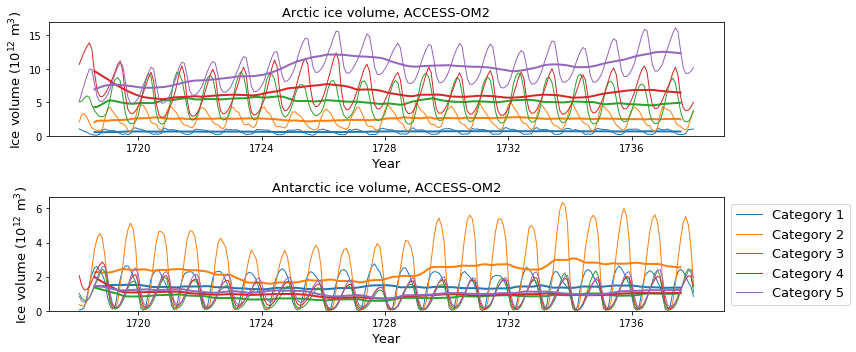

In [50]:
ekey='1deg'
loaddata(ekey)
calcvol(ekey)
plotvolNHSH()

aice_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_aice_m_240_days-since-1718-01-01_None_False.pkl
hi_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_hi_m_240_days-since-1718-01-01_None_False.pkl
hs_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_hs_m_240_days-since-1718-01-01_None_False.pkl
vicen_m
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_vicen_m_240_days-since-1718-01-01_None_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


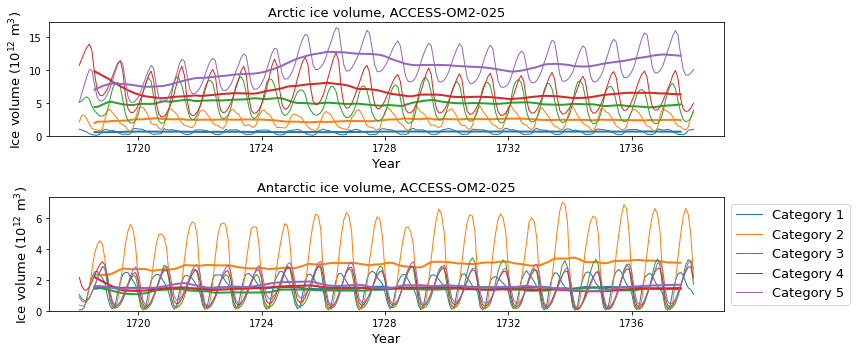

In [52]:
ekey='025deg'
loaddata(ekey)
calcvol(ekey)
plotvolNHSH()

aice_m
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_aice_m_196_days-since-1985-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_aice_m_-200_days-since-1985-01-01_None_False.pkl
hi_m
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_hi_m_196_days-since-1985-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_hi_m_-200_days-since-1985-01-01_None_False.pkl
hs_m
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_hs_m_196_days-since-1985-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_hs_m_-200_days-since-1985-01-01_None_False.pkl
vicen_m
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_vicen_m_196_days-since-1985-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-?

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


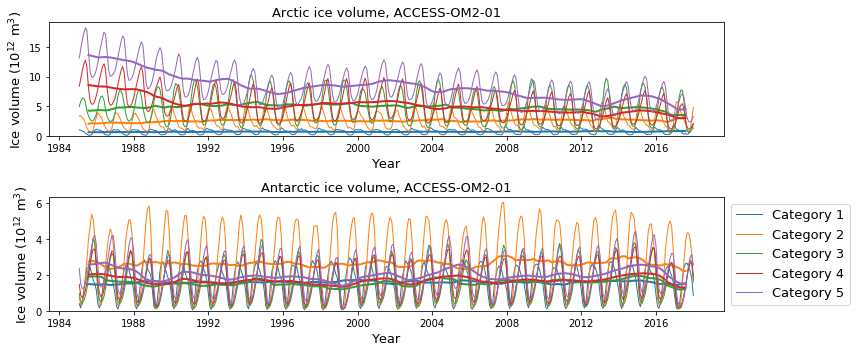

In [21]:
ekey='01deg'
loaddata(ekey)
calcvol(ekey)
plotvolNHSH()

## Seasonal cycle of sea ice extent and area
We adopt the usual definition of sea ice extent as the area in which sea ice concentration exceeds 15\%.

- obs in `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/north/monthly/data/*.csv` and  `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/south/monthly/data/*.csv`
- file names `N_mm_extent_v3.0.csv`, `S_mm_extent_v3.0.csv` where `mm` is month number
- first full year: 1979
- last full year: 2017
- missing extent data (-9999): Dec 1987, Jan 1988

CSV format:
```
year, mo,    data-type, region, extent,   area
1978, 12,      Goddard,      N,  13.67,  10.90
...
```


In [22]:
def loadObsExt(fnlist):
    """
    Return xarray DataSet of sea ice extent and area from NOAA/G02135 csv file list
    """
    df = pd.concat([pd.read_csv(f) for f in fnlist])  # read all csv files into a pandas DataFrame
    df.columns = df.columns.str.strip()  # remove leading/trailing whitespace from headers
    df['time'] = df.apply(lambda r: datetime(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
    print(df)
    df = df.drop(columns=['year', 'mo', 'data-type', 'region'])  # remove redundant columns
    num = df._get_numeric_data()
    num[num < 0] = np.nan  # replace bad data with NaN
    df = df.sort_values('time')
    ds = df.to_xarray()  # convert to xarray DataSet
    ds = ds.assign_coords(index=ds['time']).drop('time')  # set index values to time and remove time
    ds['extent'] = ds.extent.rename({'index': 'time'})  # rename extent coord to time
    ds['area'] = ds.area.rename({'index': 'time'})  # rename area coord to time
    ds = ds.drop('index')  # remove index
    ds = ds*1e12  # convert from M km^2 to m^2
    return ds

In [23]:
NH_obs = loadObsExt(obsExtNHFileList)
NH_clim_obs = NH_obs.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
# NH_extent_clim_obs = NH_climatology_obs.extent
SH_obs = loadObsExt(obsExtSHFileList)
SH_clim_obs = SH_obs.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
# SH_extent_clim_obs = SH_climatology_obs.extent

    year  mo      data-type   region   extent     area       time
0   1979   1        Goddard        N    15.41    12.41 1979-01-01
1   1980   1        Goddard        N    14.86    11.94 1980-01-01
2   1981   1        Goddard        N    14.91    11.91 1981-01-01
3   1982   1        Goddard        N    15.18    12.19 1982-01-01
4   1983   1        Goddard        N    14.94    12.01 1983-01-01
5   1984   1        Goddard        N    14.47    11.68 1984-01-01
6   1985   1        Goddard        N    14.72    11.69 1985-01-01
7   1986   1        Goddard        N    14.89    11.88 1986-01-01
8   1987   1        Goddard        N    14.97    11.90 1987-01-01
9   1988   1          -9999        N -9999.00 -9999.00 1988-01-01
10  1989   1        Goddard        N    14.95    13.18 1989-01-01
11  1990   1        Goddard        N    14.78    12.80 1990-01-01
12  1991   1        Goddard        N    14.36    12.57 1991-01-01
13  1992   1        Goddard        N    14.64    12.61 1992-01-01
14  1993  

In [24]:
def calcarea(ekey):
    global ice_data
    ide = ice_data[ekey]
    if 'NH_area' not in ide.keys():
        area = ide['aice_m']*ide['area_t']
        area_zonalsum = area.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_area'] = area_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_area'] = area_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')
        ide['NH_area_clim'] = ide['NH_area'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
        ide['SH_area_clim'] = ide['SH_area'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [25]:
def calcextent(ekey):
    global ice_data
    ide = ice_data[ekey]
    if 'NH_extent' not in ide.keys():
        extent = xr.where(ide['aice_m'] > 0.15, ide['area_t'], 0)
        extent_zonalsum = extent.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_extent'] = extent_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_extent'] = extent_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')
        ide['NH_extent_clim'] = ide['NH_extent'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
        ide['SH_extent_clim'] = ide['SH_extent'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [26]:
def plotarea(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice area (10$^{12}$ m$^2$)',font)

In [27]:
def plotareaNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotarea(NH_area, NH_obs.area)
    plt.title('Arctic ice area, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotarea(SH_area, SH_obs.area)
    plt.title('Antarctic ice area, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_area_'+ekey)

In [28]:
def plotextent(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice extent (10$^{12}$ m$^2$)',font)

In [29]:
def plotextentNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(1,2,1)
    plotextent(NH_extent, NH_obs.extent)
    plt.title('Arctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(1,2,2)
    plotextent(SH_extent, SH_obs.extent)
    plt.title('Antarctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_extent_'+ekey)

### Snow volume

In [53]:
def calcsnowvol(ekey):
    global ice_data
    ide = ice_data[ekey]
    if 'NH_snow_volume' not in ide.keys():
        svolume = ide['hs_m']*ide['area_t'] # hs_m(time, nj, ni) has units = "m", so need to multiply by `area_t` to get volume.
        svolume_zonalsum = svolume.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_snow_volume'] = svolume_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_snow_volume'] = svolume_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')

In [54]:
def plotsnowvol(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, linewidth=1)
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Snow volume (10$^{12}$ m$^3$)',font)

In [58]:
def plotsnowvolNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotsnowvol(ice_data[ekey]['NH_snow_volume'])
    plt.title('Arctic snow volume, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotsnowvol(ice_data[ekey]['SH_snow_volume'])
    plt.title('Antarctic snow volume, '+exptdata.exptdict[ekey]['desc'],font)

    plt.tight_layout()

    savefigure('snow_volume_'+ekey)

## make timeseries plots for all resolutions

1deg
aice_m
hi_m
hs_m
vicen_m
025deg
aice_m
hi_m
hs_m
vicen_m


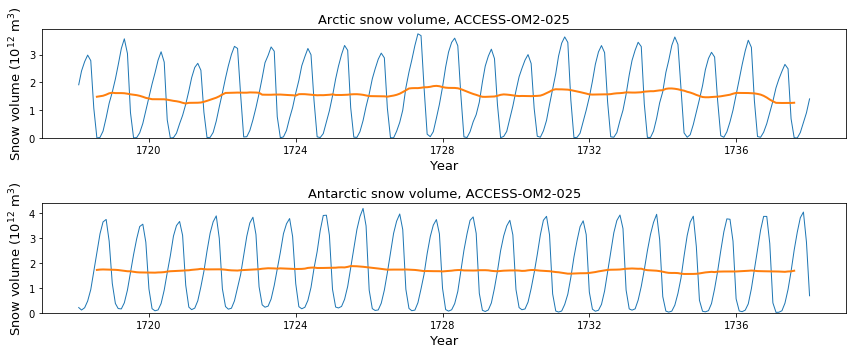

In [59]:
try:
    ice_data
except NameError:
    ice_data = copy.deepcopy(exptdata.exptdict)  # to store ice fields under the same keys as exptdata.exptdict
for ekey in ice_data.keys():
    print(ekey)
    loaddata(ekey)
    calcvol(ekey)
    calcarea(ekey)
    calcextent(ekey)
    calcsnowvol(ekey)
    plotsnowvolNHSH()

In [34]:
for ekey in ice_data.keys():
    print(ekey)
    print(type(ice_data[ekey]['NH_ice_volume'].time.values[0]))

1deg
<class 'numpy.datetime64'>
025deg
<class 'numpy.datetime64'>
01deg
<class 'numpy.datetime64'>


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


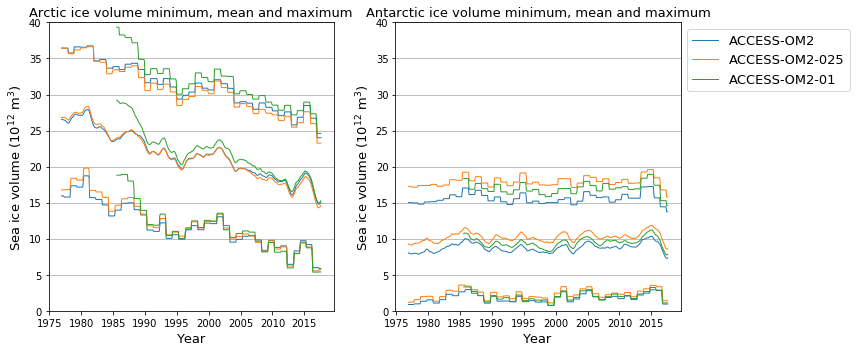

In [35]:
# 12-mo running mean minimum, mean and maximum of volume for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    totvol = ice_data[ekey]['NH_ice_volume'].sum('nc')/1e12
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(1,2,2)
    totvol = ice_data[ekey]['SH_ice_volume'].sum('nc')/1e12
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0,ymax=40)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)',font)
plt.title('Arctic ice volume minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0,ymax=40)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)',font)
plt.title('Antarctic ice volume minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

savefigure('ice_volume_min_mean_max_all')

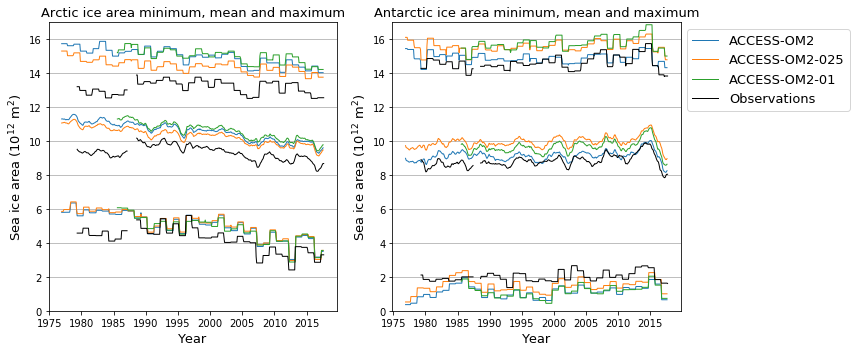

In [36]:
# 12-mo running mean minimum, mean and maximum of area for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_area']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_area']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(1,2,1)
v = NH_obs.area/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,2)
v = SH_obs.area/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0,ymax=17)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Arctic ice area minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0,ymax=17)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Antarctic ice area minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

savefigure('ice_area_min_mean_max_all')

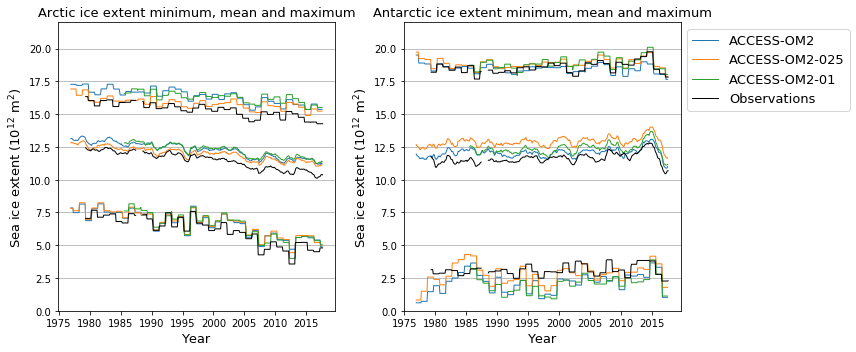

In [37]:
# 12-mo running mean minimum, mean and maximum of extent for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_extent']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_extent']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(1,2,1)
v = NH_obs.extent/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,2)
v = SH_obs.extent/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0,ymax=22)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Arctic ice extent minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0,ymax=22)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Antarctic ice extent minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

savefigure('ice_extent_min_mean_max_all')

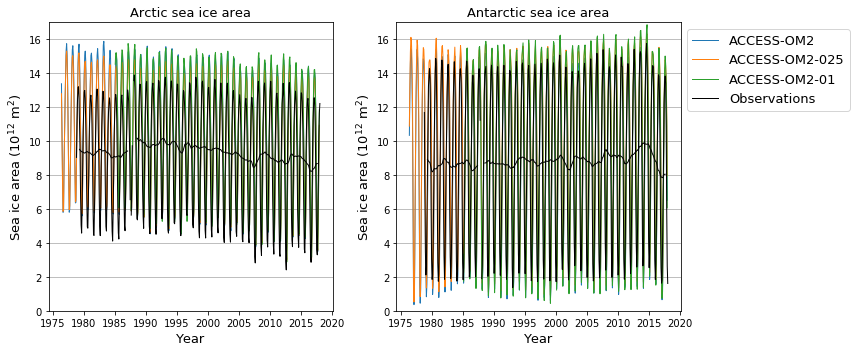

In [38]:
# 12-mo running mean and timeseries of area for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_area']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
#     plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_area']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
#     plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

plt.subplot(1,2,1)
v = NH_obs.area/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,2)
v = SH_obs.area/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0,ymax=17)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice area',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0,ymax=17)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Antarctic sea ice area',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_area_all')

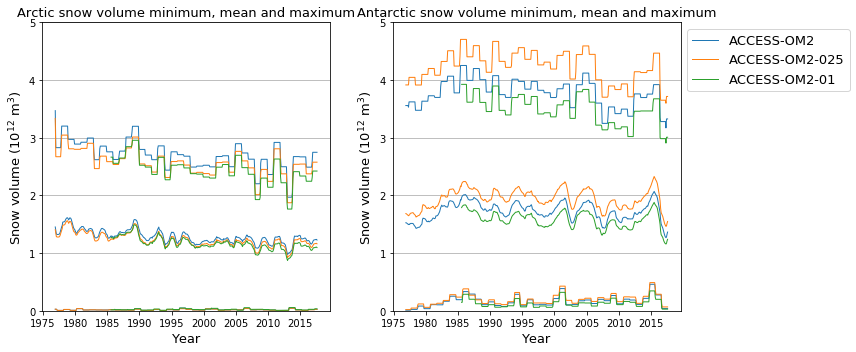

In [39]:
# 12-mo running mean minimum, mean and maximum of snow volume for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_snow_volume']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_snow_volume']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0,ymax=5)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Snow volume (10$^{12}$ m$^3$)',font)
plt.title('Arctic snow volume minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0,ymax=5)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Snow volume (10$^{12}$ m$^3$)',font)
plt.title('Antarctic snow volume minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

savefigure('snow_volume_min_mean_max_all')

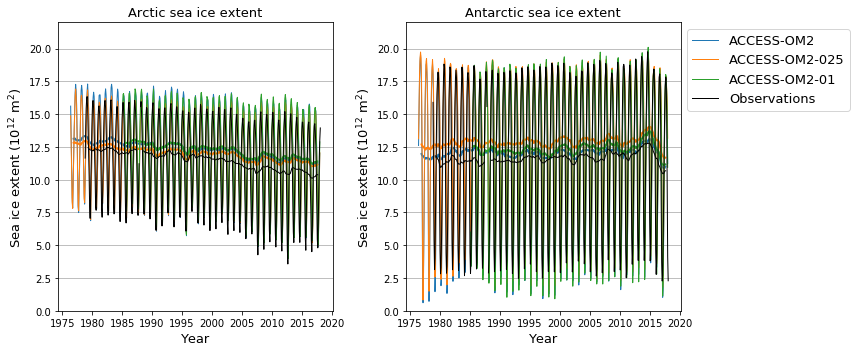

In [40]:
# 12-mo running mean and timeseries of extent for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_extent']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_extent']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

plt.subplot(1,2,1)
v = NH_obs.extent/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,2)
v = SH_obs.extent/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0,ymax=22)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice extent',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0,ymax=22)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Antarctic sea ice extent',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_extent_all')

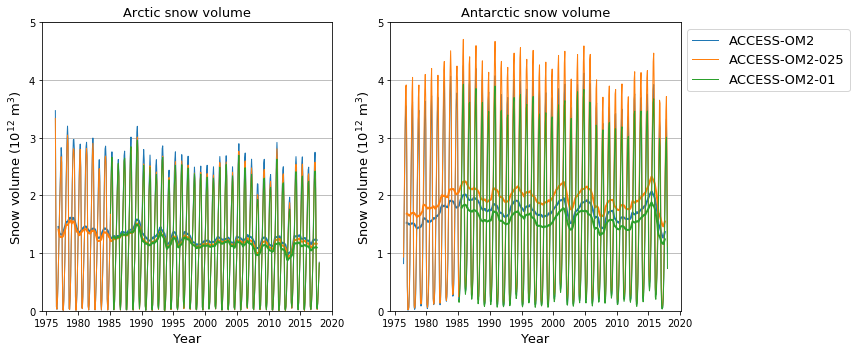

In [41]:
# 12-mo running mean and timeseries of snow volume for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_snow_volume']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_snow_volume']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

plt.subplot(1,2,1)
plt.ylim(ymin=0,ymax=5)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Snow volume (10$^{12}$ m$^3$)',font)
plt.title('Arctic snow volume',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0,ymax=5)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Snow volume (10$^{12}$ m$^3$)',font)
plt.title('Antarctic snow volume',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('snow_volume_all')

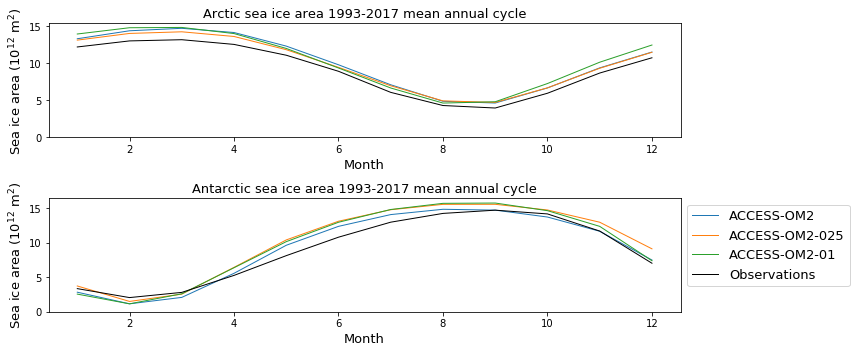

In [42]:
# seasonal cycle of area for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(2,1,1)
    v = ice_data[ekey]['NH_area']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

    plt.subplot(2,1,2)
    v = ice_data[ekey]['SH_area']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

plt.subplot(2,1,1)
v = NH_obs.area/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,2)
v = SH_obs.area/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,1)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice area '+yearrange+' mean annual cycle',font)
plt.subplot(2,1,2)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Antarctic sea ice area '+yearrange+' mean annual cycle',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_area_seasonal_clim')

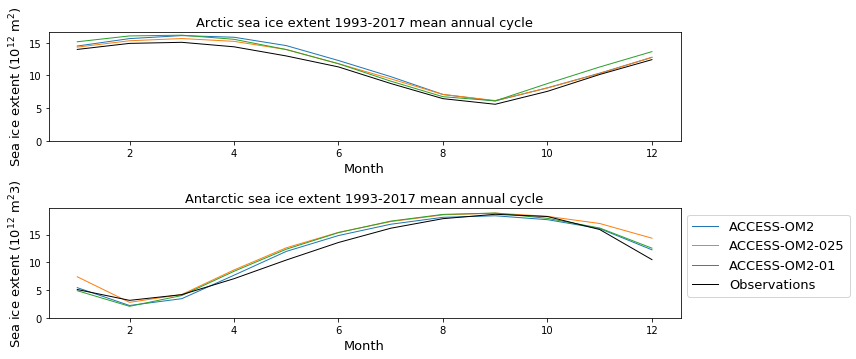

In [43]:
# seasonal cycle of extent for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(2,1,1)
    v = ice_data[ekey]['NH_extent']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

    plt.subplot(2,1,2)
    v = ice_data[ekey]['SH_extent']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

plt.subplot(2,1,1)
v = NH_obs.extent/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,2)
v = SH_obs.extent/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,1)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice extent '+yearrange+' mean annual cycle',font)
plt.subplot(2,1,2)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^23$)',font)
plt.title('Antarctic sea ice extent '+yearrange+' mean annual cycle',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_extent_seasonal_clim')

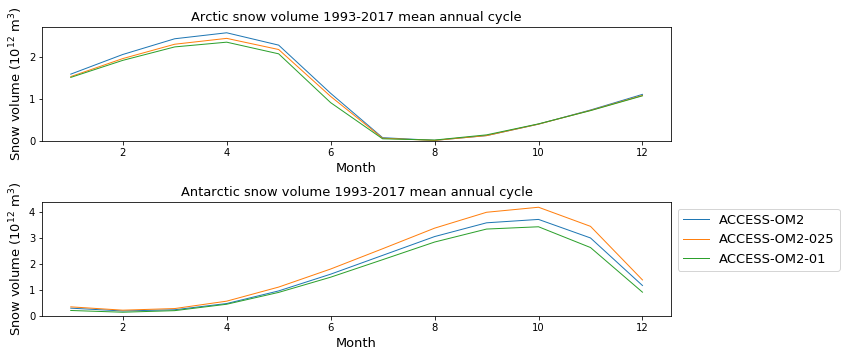

In [44]:
# seasonal cycle of snow volume for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(2,1,1)
    v = ice_data[ekey]['NH_snow_volume']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

    plt.subplot(2,1,2)
    v = ice_data[ekey]['SH_snow_volume']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

plt.subplot(2,1,1)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Snow volume (10$^{12}$ m$^3$)',font)
plt.title('Arctic snow volume '+yearrange+' mean annual cycle',font)
plt.subplot(2,1,2)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Snow volume (10$^{12}$ m$^3$)',font)
plt.title('Antarctic snow volume '+yearrange+' mean annual cycle',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('snow_volume_seasonal_clim')

## 6-panel plot for paper

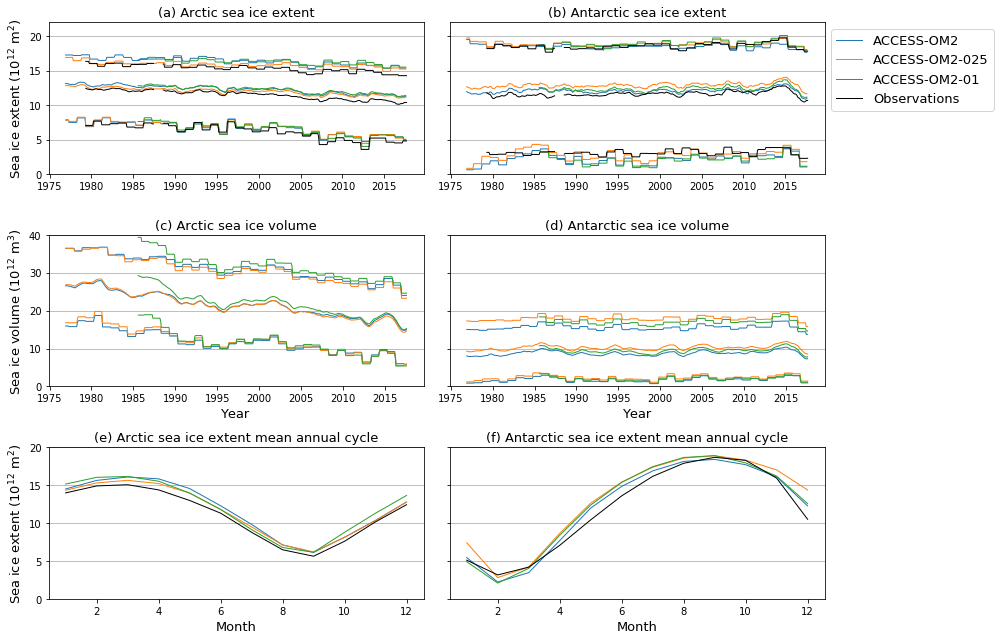

In [63]:
plt.figure(1,(14,9))

# 12-mo running mean minimum, mean and maximum of extent for all models
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(3,2,1)
    v = ice_data[ekey]['NH_extent']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(3,2,2)
    v = ice_data[ekey]['SH_extent']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(3,2,1)
v = NH_obs.extent/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(3,2,2)
v = SH_obs.extent/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

ax = plt.subplot(3,2,1)
plt.ylim(ymin=0,ymax=22)
plt.grid(axis='y')
# ax.set_xticklabels([])
# plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('(a) Arctic sea ice extent',font)
ax = plt.subplot(3,2,2)
plt.ylim(ymin=0,ymax=22)
plt.grid(axis='y')
ax.set_yticklabels([])
# ax.set_xticklabels([])
# plt.xlabel('Year',font)
# plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('(b) Antarctic sea ice extent',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

# 12-mo running mean minimum, mean and maximum of volume for all models
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(3,2,3)
    totvol = ice_data[ekey]['NH_ice_volume'].sum('nc')/1e12
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(3,2,4)
    totvol = ice_data[ekey]['SH_ice_volume'].sum('nc')/1e12
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(3,2,3)
plt.ylim(ymin=0,ymax=40)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)',font)
plt.title('(c) Arctic sea ice volume',font)
ax = plt.subplot(3,2,4)
plt.ylim(ymin=0,ymax=40)
plt.grid(axis='y')
plt.xlabel('Year',font)
ax.set_yticklabels([])
# plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)',font)
plt.title('(d) Antarctic sea ice volume',font)
# plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

# seasonal cycle of extent for all models
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(3,2,5)
    v = ice_data[ekey]['NH_extent']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

    plt.subplot(3,2,6)
    v = ice_data[ekey]['SH_extent']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

plt.subplot(3,2,5)
v = NH_obs.extent/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(3,2,6)
v = SH_obs.extent/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(3,2,5)
plt.ylim(ymin=0,ymax=20)
plt.grid(axis='y')
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('(e) Arctic sea ice extent mean annual cycle',font)
ax = plt.subplot(3,2,6)
plt.ylim(ymin=0,ymax=20)
plt.grid(axis='y')
plt.xlabel('Month',font)
ax.set_yticklabels([])
# plt.ylabel(r'Sea ice extent (10$^{12}$ m$^23$)',font)
plt.title('(f) Antarctic sea ice extent mean annual cycle',font)
# plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_extent_volume_seasonal_clim')